In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
from pylab import *

In [2]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cmap_type, alpha):
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap(cmap_type)

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap_img = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap_img)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return jet_heatmap_img, superimposed_img
    

## start here

In [3]:
model_path = r'C:\Users\ee527\Dementia_Vision_beta\model\test.h5'

# D:\Dementia_Data_Preprocessing\main\label_image\4\20210819_t050450.jpg
test_img = r"D:\Dementia_Data_Preprocessing\main\out_image\20211023_t041902.jpg"


image = cv2.imread(test_img)
INPUT_SIZE = 128
image = cv2.resize(image, (INPUT_SIZE,INPUT_SIZE))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
model = tf.keras.models.load_model(model_path)
preds = model.predict(image) 
print(preds[0][0])

if preds[0][0]>0.5:
    label = 1
else:
    label = 0
    
print("label:", label)

0.9990165
label: 1


In [4]:
# see all layer
for idx in range(len(model.layers)):
    print(model.get_layer(index = idx).name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_max_pooling2d
dropout
batch_normalization
dropout_1
dense


## show heat map
### color map type:
![jupyter](img/color_map.png)

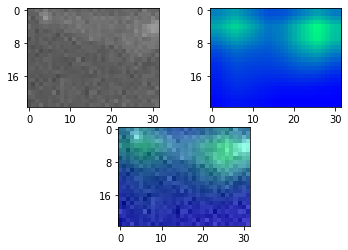

In [13]:
# Prepare image
INPUT_SIZE = 128
model_path = r'C:\Users\ee527\Dementia_Vision_beta\model\test.h5'
test_img = r"D:\Dementia_Data_Preprocessing\main\out_image\20211023_t022918.jpg"

image = cv2.imread(test_img)
image2 = cv2.resize(image, (INPUT_SIZE,INPUT_SIZE))

image3 = image2.astype('float32') / 255
img_array = np.expand_dims(image3, axis=0)

model = tf.keras.models.load_model(model_path)
last_conv_layer_name = "block5_conv3"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        
# Display heatmap

# rescale to original size
heatmap = cv2.resize(heatmap, (32,24))

# 原圖反轉黑白，顯示效果較明顯
dst = 255 - image
heat, combine = save_and_display_gradcam(image, heatmap, cmap_type = "winter", alpha = 0.3)



ax = plt.gca()
plt.subplot(221)
imshow(image)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(8))

plt.subplot(222)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(8))
imshow(heat)


plt.subplot(212)
imshow(combine)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(8))
plt.show()

In [67]:
heat.save("D:/heatmap/heat.png")
combine.save("D:/heatmap/combine.png")

## create mask and bbox

In [68]:
import cv2

# Grayscale then Otsu's threshold
image2 = cv2.imread('D:/heatmap/heat.png')

image_copy = image2

gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0,255,255), 1)  # 2畫線, -1 填滿
    print(x,y,w,h)


gray1 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
final = cv2.bitwise_and(gray1, thresh)

#cv2.imwrite("D:/heatmap/final.png",final)
cv2.imwrite("D:/heatmap/mask.png",thresh)  
cv2.imwrite("D:/heatmap/bbox.png",image_copy) 


# cv2.imshow('thresh', thresh)
# cv2.imshow('image', image_copy)
# cv2.imshow('final', final)
# cv2.waitKey()

30 20 2 4
2 4 30 12
29 0 3 4
0 0 2 2


True

## get body location

In [9]:
import cv2

# Grayscale then Otsu's threshold
image = cv2.imread('D:/test.png')

size = image.shape
print(size)

image_copy = image

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    print(x,y,w,h)
    
# 上
up = y
# 下
down = 24 - (y+h)
# 左
left = x
#右
right = 32-(x+w)

print(up,down,left, right)

(24, 32, 3)
0 2 32 17
2 5 0 0


## start run path

In [3]:
import cv2
import os
import random
import numpy as np

# 修改路徑
directory_name = r"D:\Dementia_Data_Preprocessing\main\out_image"
new_directory_name = r"D:\test3\heat"
new_directory_name_2 = r"D:\test3\combine"
new_directory_name_3 = r"D:\test3\bbox"
new_directory_name_4 = r"D:\test3\mask"

model_path = r'C:\Users\ee527\Dementia_Vision_beta\model\test.h5'
INPUT_SIZE = 128
model = tf.keras.models.load_model(model_path)
last_conv_layer_name = "block5_conv2"

count = 0
for filename in os.listdir(directory_name):
    
    
    count+=1
  
    
    image = cv2.imread(directory_name + "/" + filename)
    image_copy = image
    image2 = cv2.resize(image, (INPUT_SIZE,INPUT_SIZE))

    image3 = image2.astype('float32') / 255
    img_array = np.expand_dims(image3, axis=0)

    
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # rescale to original size
    heatmap = cv2.resize(heatmap, (32,24))
    heat, combine = save_and_display_gradcam(image, heatmap, cmap_type = "winter", alpha = 0.3)
    #heat, combine = save_and_display_gradcam(image, heatmap, cmap_type = "jet", alpha = 0.3)
    
    heat.save(new_directory_name + "/" + filename)
    combine.save(new_directory_name_2 + "/" + filename)
    
    heat = np.array(heat)
    gray = cv2.cvtColor(heat, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0,255,255), 1)  # 2畫線, -1 填滿    
    
    #gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #final = cv2.bitwise_and(gray1, thresh)
        
    cv2.imwrite(new_directory_name_3 + "/" + filename, image_copy)
    cv2.imwrite(new_directory_name_4 + "/" + filename, thresh)
    
print("finish")
print(f"total number:{count}")

finish
total number:1
